In [1]:
import joblib
import os
import tensorflow as tf
import keras
import numpy as np

In [4]:
from text_prep import load_dataset

In [4]:
# captions = clean_descriptions(load_descriptions(path))

In [5]:
train_path = 'data/Flickr8k_text/Flickr_8k.trainImages.txt'
test_path = 'data/Flickr8k_text/Flickr_8k.testImages.txt'

In [6]:
train_dataset = load_dataset(train_path)
test_dataset = load_dataset(test_path)

In [7]:
captions = joblib.load('captions.pkl')

In [8]:
features = joblib.load('features.pkl')

In [9]:
def load_feat_descr(dict, dataset):
    return {k: dict[k] for k in dataset}

In [10]:
captions_train = load_feat_descr(captions, train_dataset)
features_train = load_feat_descr(features, train_dataset)
captions_test = load_feat_descr(captions, test_dataset)
features_test = load_feat_descr(features, test_dataset)

In [11]:
from keras.preprocessing.text import Tokenizer
from text_prep import to_vocabulary

In [12]:
vocab = to_vocabulary(captions_train)

In [14]:
len(vocab)

5785

In [13]:
vc = keras.layers.TextVectorization(
    vocabulary = ['startseq'] + list(vocab) + ['endseq']
)

2022-06-23 12:12:40.279527: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
max_len = 0
for key in captions_train.keys():
    for d in captions_train[key]:
        max_len = max(max_len, len(d))
max_len        

36

In [16]:
from keras.utils import pad_sequences

In [70]:
def sequencer(dataset, captions, features):
    X_1, X_2, y = [], [], []
    for key in dataset:
        for desc in captions[key]:
            seq = ['startseq'] + desc + ['endseq']
            seq = vc(seq)
            for i in range(1, len(seq)-1):
                X_1.append(features[key][0])
                X_2.append(seq[:i])
                y.append(seq[i])
    X_2 = pad_sequences(X_2, maxlen=max_len)
    return np.array(X_1), X_2.reshape((X_2.shape[0],X_2.shape[1])), np.array(y)

In [71]:
X_1_train, X_2_train, y_train = sequencer(train_dataset, captions_train, features)
X_1_test, X_2_test, y_test = sequencer(test_dataset, captions_test, features)

In [72]:
print(X_1_train.shape)
print(X_2_train.shape)
print(y_train.shape)

(324018, 1000)
(324018, 36)
(324018, 1)


In [73]:
print(X_1_test.shape)
print(X_2_test.shape)
print(y_test.shape)

(54237, 1000)
(54237, 36)
(54237, 1)


In [65]:
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, add
from keras.models import Model
from keras.callbacks import ModelCheckpoint

In [74]:
inputs_fe = Input(shape=(1000,))
fe1 = Dropout(0.5)(inputs_fe)
fe2 = Dense(256, activation='relu')(fe1)

inputs_se = Input(shape=(max_len,))
se1 = Embedding(len(vocab)+2, 256, mask_zero=True)(inputs_se)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(len(vocab)+2, activation='softmax')(decoder2)

model = Model(inputs=[inputs_fe, inputs_se], outputs=outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

In [75]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 36)]         0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 1000)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 36, 256)      1481472     ['input_8[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 1000)         0           ['input_7[0][0]']                
                                                                                            

In [76]:
# define checkpoint callback
filepath = './models/model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [197]:
model.fit(
    [X_1_train[:10000], X_2_train[:10000]], 
    y_train[:10000], 
    epochs=10,
    callbacks=[checkpoint], 
    validation_data=([X_1_test[:10000], X_2_test[:10000]], y_test[:10000])
    )

Epoch 1/10
313/313 [==============================] - ETA: 0s - loss: 4.6736
Epoch 1: val_loss improved from 5.22047 to 4.64023, saving model to ./models/model-ep001-loss4.674-val_loss4.640.h5
313/313 [==============================] - 136s 433ms/step - loss: 4.6736 - val_loss: 4.6402
Epoch 2/10
313/313 [==============================] - ETA: 0s - loss: 3.9643
Epoch 2: val_loss improved from 4.64023 to 4.61622, saving model to ./models/model-ep002-loss3.964-val_loss4.616.h5
313/313 [==============================] - 133s 424ms/step - loss: 3.9643 - val_loss: 4.6162
Epoch 3/10
313/313 [==============================] - ETA: 0s - loss: 3.6772
Epoch 3: val_loss did not improve from 4.61622
313/313 [==============================] - 132s 422ms/step - loss: 3.6772 - val_loss: 4.6690
Epoch 4/10
313/313 [==============================] - ETA: 0s - loss: 3.4625
Epoch 4: val_loss did not improve from 4.61622
313/313 [==============================] - 142s 455ms/step - loss: 3.4625 - val_loss: 4

In [241]:
image = features[list(features.keys())[207]]

In [233]:
def predict(model, vc, image, max_len):
    desc = ['startseq']
    for i in range(36):   
        desc_tok = pad_sequences([vc(desc)], maxlen=max_len).reshape((1,36))
        pred = model.predict([image, desc_tok], verbose=0)
        pred_text = vc.get_vocabulary()[np.argmax(pred)]
        desc.append(pred_text)
    return desc

In [236]:
desc = predict(model, vc, image, max_len)
desc

['startseq',
 'a',
 'man',
 'be',
 'hold',
 'a',
 'religious',
 'train',
 'car',
 'in',
 'the',
 'camera',
 'while',
 'another',
 'man',
 'be',
 'watch',
 'the',
 'camera',
 'while',
 'another',
 'man',
 'be',
 'watch',
 'the',
 'camera',
 'in',
 'the',
 'camera',
 'watch',
 'he',
 'be',
 'stand',
 'in',
 'a',
 'blue',
 'wall']

In [176]:
from keras.utils import load_img
directory = 'data/Flicker8k_Dataset'

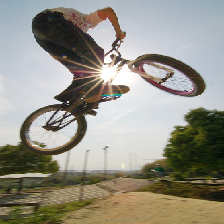

In [243]:
name = list(features.keys())[207]
picture = load_img(directory + '/' + name + '.jpg', target_size=(224,224))
picture

In [238]:
from model import RnnModel

In [239]:
model_path = 'models/model-ep002-loss3.964-val_loss4.616.h5'
from keras.models import load_model

rnn = RnnModel(load_model(model_path), vc, max_len)

In [242]:
rnn.predict(image)

['startseq',
 'a',
 'man',
 'be',
 'be',
 'run',
 'on',
 'a',
 'red',
 'shirt',
 'on',
 'a',
 'red',
 'shirt',
 'and',
 'a',
 'red',
 'shirt',
 'and',
 'a',
 'red',
 'shirt',
 'and',
 'a',
 'red',
 'shirt',
 'and',
 'a',
 'red',
 'shirt',
 'and',
 'a',
 'red',
 'shirt',
 'and',
 'a',
 'red']

36.787944117144235

Secretary problem

In [251]:
a = [1,2,3]
np.random.shuffle(a)


[1, 3, 2]

In [267]:
def max_finder(k, n):
    a = [i for i in range(n)]
    np.random.shuffle(a)
    pre_max = max(a[:k])
    for i in a[k:]:
        if i>pre_max:
            return i
    return -1


In [272]:
max_finder(3,10)

7

In [301]:
succes_list = []
for k in range(100):
    succes = 0
    for i in range(10000):
        if max_finder(k+1,100) in [99]:
            succes += 1
    succes_list.append(succes)
succes_list.index(max(succes_list))

35

In [290]:
100/np.e

36.787944117144235

In [292]:
import matplotlib.pyplot as plt

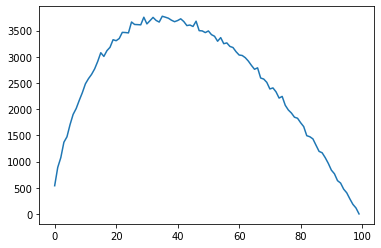

In [302]:
plt.plot(succes_list)

In [303]:
succes_list[35]

3773